Based on CNN paper [Convolutional neural networks for images, speech and time-series](https://www.researchgate.net/profile/Yann_Lecun/publication/2453996_Convolutional_Networks_for_Images_Speech_and_Time-Series/links/0deec519dfa2325502000000.pdf), Yann LeCun & Yoshua Bengio, 1995

In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm import tqdm

Create data loaders

In [23]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ])

trainset = datasets.MNIST('./datasets/', download=True,
                          train=True, transform=transform)
valset = datasets.MNIST('./datasets', download=True,
                        train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

Test data

torch.Size([64, 1, 28, 28])
torch.Size([64])


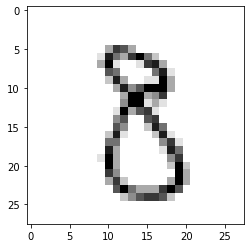

In [24]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


Custom convolution layer

In [25]:
class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(CustomConv2d, self).__init__()

        self.weigths = nn.Parameter(torch.rand(out_channels, in_channels, *kernel_size))

    def forward(self, input: Tensor) -> Tensor:
        return F.conv2d(input, self.weigths)

Define network architecture

In [33]:
class CNNModule(nn.Module):
    def __init__(self):
        super(CNNModule, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            # CustomConv2d(in_channels=1, out_channels=16, kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            # nn.Conv2d(16, 32, 5, 1, 2),
            nn.Conv2d(16, 32, 5, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 5 * 5, 10)

    def forward(self, input: Tensor) -> Tensor:
        x = self.conv1(input)
        x = self.conv2(x)
        return self.out(x.view(x.size(0),-1))


Create network instance and test output

In [34]:
net = CNNModule()
print(net)

data_item = iter(train_loader).next()[0]
print(data_item.size())
output = net.forward(data_item)
print("Output size:", output.size())

CNNModule(
  (conv1): Sequential(
    (0): CustomConv2d()
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=800, out_features=10, bias=True)
)
torch.Size([64, 1, 28, 28])
Output size: torch.Size([64, 10])


Push network to GPU if possible

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

if(torch.cuda.is_available):
    torch.cuda.empty_cache()
    net.to(device)

Accuracy and error validation

In [37]:
def calc_acc(net, device, loader):
    correct_count, all_count = 0, 0
    for images, labels in loader:
        labels = labels.to(device)
        images = images.to(device)

        with torch.no_grad():
            out = net.forward(images)
            out = torch.argmax(out, dim=1)
            correct_count += torch.sum(labels == out).item()

        all_count += labels.size(0)

    print("Number Of Images Tested =", all_count)
    print("Model Accuracy =", (correct_count/all_count))

Training routine

In [39]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 3

for e in range(epochs):
    print(f'\n---Epoch: {e}')
    running_loss = 0.

    pbar = tqdm(train_loader)
    for images, labels in pbar:

        labels = nn.functional.one_hot(labels, num_classes=10).float().to(device)
        images = images.to(device)

        out = net.forward(images)
        loss = loss_func(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        pbar.set_postfix_str(f"Loss: {running_loss/(pbar.last_print_n+1)}")
    
    calc_acc(net, device, val_loader)



---Epoch: 0


100%|██████████| 938/938 [00:19<00:00, 48.90it/s, Loss: 0.10506768055331152]


Number Of Images Tested = 10000
Model Accuracy = 0.9707

---Epoch: 1


 46%|████▌     | 430/938 [00:09<00:11, 45.36it/s, Loss: 0.09722725282361327]


KeyboardInterrupt: 

Test model predictions

Prediction: 4


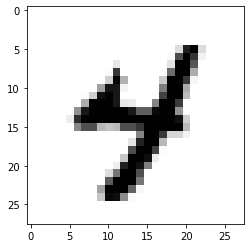

In [38]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

with torch.no_grad():
    images = images.to(device)

    out = net.forward(images)

print("Prediction:", torch.argmax(out[0]).item())    
